In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import gamma

import pennylane as qml

from HDT_circuit import HEA_circuit_bits

For each shot of measurement, we obtain one realization of the random bitstrings $(Z_A, Z_B)$. By Bayes' theorem, $$P(Z_A=0\mid Z_B)=\frac{P(Z_B\mid Z_A=0)P(Z_A=0)}{P(Z_B)}.$$ We can therefore estimate $P(Z_A=0\mid Z_B=z_B)$ by $$\hat{P}=\frac{(\#[Z_A=0, Z_B=z_B]/\#[Z_A=0])\cdot(\#[Z_A=0]/\#\text{Shots})}{\#[Z_B=z_B]/\#\text{Shots}}=\frac{\#[Z_A=0, Z_B=z_B]}{\#[Z_B=z_B]}$$

In [2]:
def get_cond_prob(bit_string):
    ZA = bit_string[:, :2]
    ZB = bit_string[:, 2:]

    A0_idx = np.all(ZA == [0, 0], axis=1)
    ZB_A0 = ZB[A0_idx]

    unq, inv, counts = np.unique(
        ZB, axis=0, return_inverse=True, return_counts=True)
    num_ZB = counts[inv]

    _, inv_B, counts_B = np.unique(
        np.vstack((unq, ZB_A0)), axis=0, return_inverse=True, return_counts=True)
    counts_new = counts_B[inv_B[:len(unq)]] - 1
    num_ZB_A0 = counts_new[inv]

    return num_ZB_A0 / num_ZB

## 2 Qubits, HEA circuit

In [3]:
shots = 1000000
n_step = 6
n_bath = 2
n_wires = 2 + n_bath * n_step
dev = qml.device('default.qubit', wires=n_wires, shots=shots)
qnode = qml.QNode(HEA_circuit_bits, dev)

In [4]:
depth = 5
weights_data = np.random.uniform(0, 4. * np.pi, (n_step, depth, 4))
weights_ancilla = np.random.uniform(0, 4. * np.pi, (n_bath, n_step, depth, 2))
# qml.draw_mpl(qnode)(weights_data, weights_ancilla);

In [5]:
res = qnode(weights_data, weights_ancilla)
phat = get_cond_prob(res)

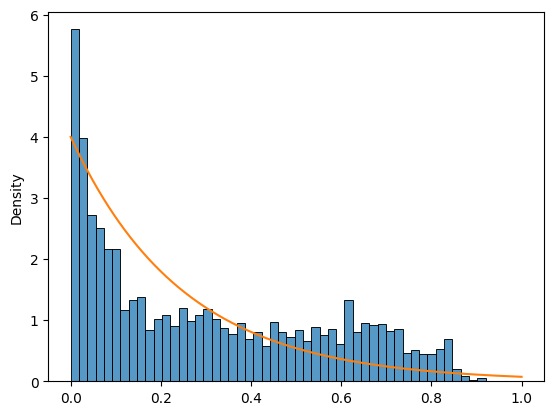

In [6]:
z = np.linspace(0, 1, 1000)
pt_dist = gamma.pdf(z, 1, scale=0.25)

sns.histplot(phat, bins=50, stat='density');
plt.plot(z, pt_dist, color='tab:orange');

In [7]:
# sanity check

# num_ZB_A0 = []
# num_ZB = []
# ZB = res[:, 2:]
# for z in res:
#     zb = z[2:]
#     zb_a0 = np.hstack(([0, 0], zb))

#     n_num = np.all(res == zb_a0, axis=1).sum()
#     n_den = np.all(ZB == zb, axis=1).sum()

#     num_ZB_A0.append(n_num)
#     num_ZB.append(n_den)

# phat2 = np.array(num_ZB_A0) / np.array(num_ZB)
# np.equal(phat2, phat).all()

## Multiple Histograms


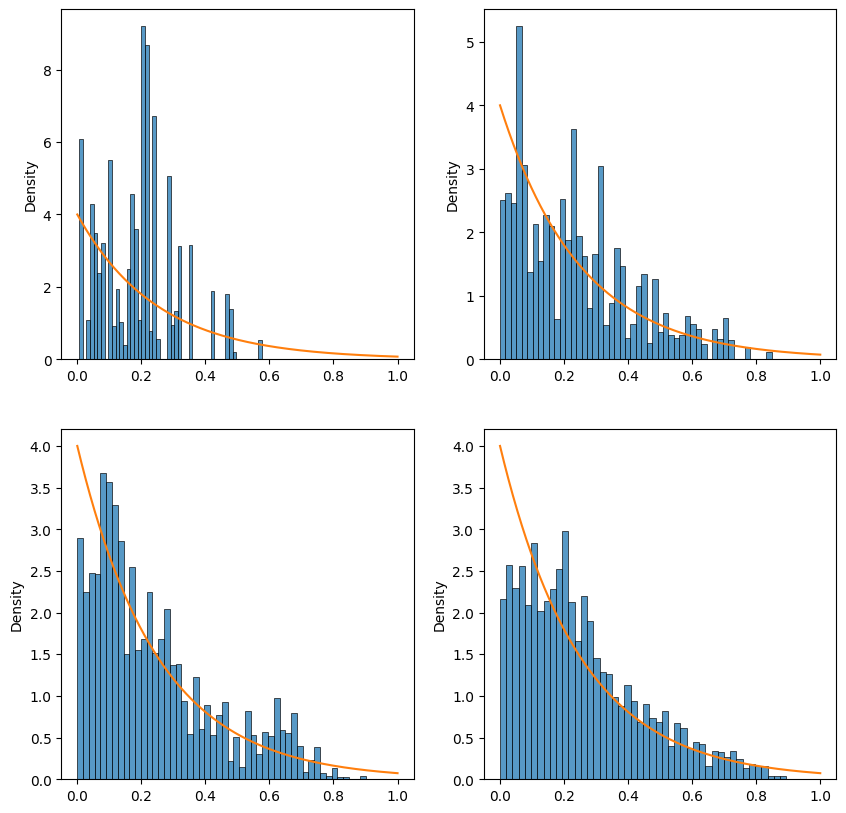

In [8]:
shots = 1000000
n_bath = 2
depth = 5

z = np.linspace(0, 1, 1000)
pt_dist = gamma.pdf(z, 1, scale=0.25)

steps = [3, 4, 5, 6]
fig, ax = plt.subplots(2, 2, figsize=(10, 10))
for i, n_step in enumerate(steps):
    n_wires = 2 + n_bath * n_step
    dev = qml.device('default.qubit', wires=n_wires, shots=shots)
    qnode = qml.QNode(HEA_circuit_bits, dev)
    weights_data = np.random.uniform(0, 4. * np.pi, (n_step, depth, 4))
    weights_ancilla = np.random.uniform(0, 4. * np.pi, (n_bath, n_step, depth, 2))

    res = qnode(weights_data, weights_ancilla)
    phat = get_cond_prob(res)

    sns.histplot(phat, bins=50, stat='density', ax=ax[i // 2, i % 2]);
    ax[i // 2, i % 2].plot(z, pt_dist, color='tab:orange');


## Noise Simulation

In [9]:
# from qiskit_aer import AerSimulator
from qiskit_aer.noise import NoiseModel
# from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_ibm_runtime.fake_provider import FakeTorino

noise_model = NoiseModel.from_backend(FakeTorino())

In [10]:
shots = 100000
n_step = 6
n_bath = 2
depth = 5
n_wires = 2 + n_bath * n_step
dev = qml.device("qiskit.aer", wires=n_wires, noise_model=noise_model, shots=shots)
qnode = qml.QNode(HEA_circuit_bits, dev)

In [11]:
weights_data = np.random.uniform(0, 4. * np.pi, (n_step, depth, 4))
weights_ancilla = np.random.uniform(0, 4. * np.pi, (n_bath, n_step, depth, 2))
res = qnode(weights_data, weights_ancilla)
phat = get_cond_prob(res)

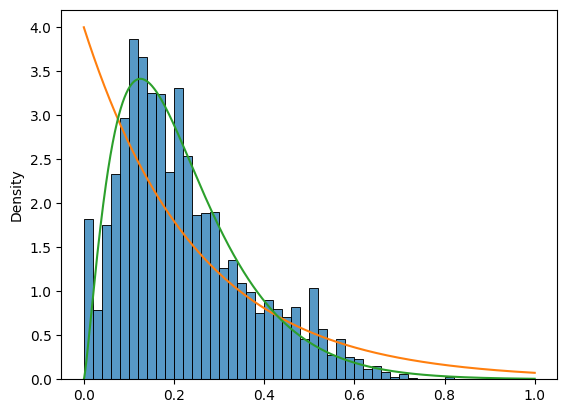

In [18]:
z = np.linspace(0, 1, 1000)
pt_dist = gamma.pdf(z, 1, scale=0.25)

mean = phat.mean()
alpha = mean ** 2. / phat.var()
beta  = mean / alpha
ga_dist = gamma.pdf(z, alpha, scale=beta)

sns.histplot(phat, bins=50, stat='density');
plt.plot(z, pt_dist, color='tab:orange');
plt.plot(z, ga_dist, color='tab:green');

## True Haar

In [13]:
def qr_haar(N):
    """Generate a Haar-random matrix using the QR decomposition."""
    # Step 1
    A, B = np.random.normal(size=(N, N)), np.random.normal(size=(N, N))
    Z = A + 1j * B

    # Step 2
    Q, R = np.linalg.qr(Z)

    # Step 3
    Lambda = np.diag([R[i, i] / np.abs(R[i, i]) for i in range(N)])

    # Step 4
    return np.dot(Q, Lambda)


In [14]:
dev = qml.device('default.mixed', wires=2, shots=5000)
@qml.qnode(dev)
def qr_haar_random_unitary():
    qml.QubitUnitary(qr_haar(4), wires=[0, 1])
    return qml.probs()

xx = np.array([qr_haar_random_unitary()[0] for i in range(5000)])

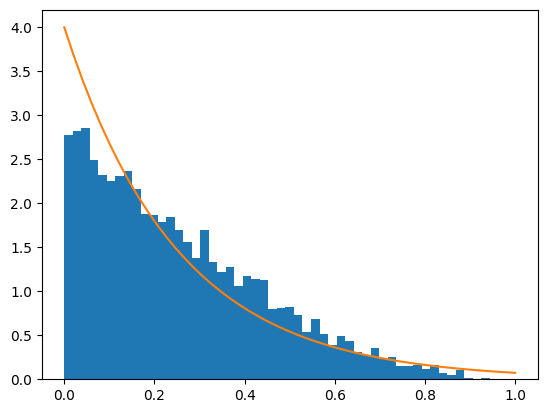

In [15]:
z = np.linspace(0, 1)
pt_dist = gamma.pdf(z, a=1, scale=1. / 2 ** 2)
plt.hist(xx, bins=50, density=True)
plt.plot(z, pt_dist)